In [1]:
# Initialisation du notebook en important les différents modules nécessaires
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# Initialisation du client PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation des modules Python nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn import neighbors, metrics,preprocessing,model_selection,linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

     |████████████████████████████████| 993kB 4.9MB/s 


Ce notebook a été créé dans le but de réaliser un projet de parcours Data Scientist, à savoir réaliser une application innovante dans le domaine de l'alimentation. Projet réparti en deux notebooks différents, cette première partie aura pour but de créer un fichier d'intérêt pour créer cette application.

Pour cela, nous utilisons la base de données libre Open Food Facts, association à but non lucratif ayant regroupé, à l'aide de volontaires, les informations complètes  sur les produits vendus dans le commerce. Cependant, comme toute base de données libre complétée par toutes les personnes le désirant, il y a forcément des informations incomplètes ou manquantes, ce qui va tout d'abord nécéssiter un tri des informations disponibles et utilisables pour une future application. 

# Sommaire
1. Description générale du fichier de données
2. Création du fichier nettoyé des produits français
3. Analyse visuelle de notre fichier de produits français

# 1. Description générale du fichier de données

In [2]:
#Importation des données dans le notebook, à partir du Google Drive
link1="https://drive.google.com/open?id=1dtrXLgf16WzEwYyZRmYRw61UEwFxWGko" 
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('en.openfoodfacts.org.products.csv')  
data = pd.read_csv('en.openfoodfacts.org.products.csv',sep='\t')
print ("Data importées")



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data importées


Nous allons donc analyser chaque colonne une par une, afin d'en étudier le contenu.
Commençons donc tout d'abord par les informations générales :


*   Les codes produits, correspondant donc aux code-barres (ou un nombre créé automatiquement en son absence). Cependant, nous pouvons donc qu'il y a 390 codes dupliqués, donc potentiellement 390 produits avec plusieurs codes différents.
*   Les URLs sont les liens permettant d'accéder aux différents produits : il y a le même nombre de liens que de produits. Il semblerait cependant que des liens puissent être le même pour deux produits dans 127 cas, ce qui semble étrange et problématique.
*   Les créateurs sont les personnes ayant ajouté les différents produits. Il n'y en a d'ailleurs pas pour 3 produits (peut-être ceux créés par défaut à la création de la base de données), et plus de 8000 personnes ont ajoutées des produits, même si une personne en a ajouté presque la moitié. 
*   La première date d'ajout des produits correspond au nombre de secondes depuis le 1er janvier 1970 (UNIX timestamp) auquel le produit a été ajouté dans la base. Il y a bien une valeur par produit, mais nécessitera une conversion en date pour être utilisable
*   La deuxième date d'ajout des produits correspond à la date d'ajout du produit dans la base. Ce sera donc la variable utilisable pour la date d'ajout, même s'il manque une des valeurs.
*   Les deux dates de dernière modification des produits fonctionnent de la même manière que les dates d'ajout. L'une est en UNIX timestamp, l'autre est une date :  nous conserverons donc la deuxième variable, sachant qu'elle contient bien une valeur par produit. 
*   Le nom du produit est donc la manière dont le produit est appelé. Cependant, un produit peut avoir le même nom que d'autres, et plus de 66000 produits n'ont pas de nom. 
*   Le nom générique reste encore assez flou. Il n'existe cependant que très peu de données pour ce critère (<100000).
*   La quantité du produit est donc par exemple le poids de vente du produit en question. Cependant, en plus de n'avoir que peu de valeurs disponibles (<300000), les unités de ces quantités ne sont pas harmonisées.

De ces informations générales, nous pouvons déjà déconsidérer les dates en UNIX timstamps. Il nous faudra également harmoniser si possible des quantités de produits (tout en grammes ?) et trouver le moyen de nommer les produits sans nom ou nom générique.

In [3]:
print (data[["code","url","creator"]].describe (include="all"))
print (data[["created_t","created_datetime","last_modified_t"]].describe (include="all"))
print (data[["last_modified_datetime","product_name"]].describe (include="all"))
print (data[["generic_name","quantity"]].describe (include="all"))

          code                                                url  creator
count   897938                                             897938   897935
unique  897548                                             897811     8819
top     741538  http://world-en.openfoodfacts.org/product/0055...  kiliweb
freq         3                                                  2   428618
           created_t      created_datetime  last_modified_t
count   8.979380e+05                897937     8.979380e+05
unique           NaN                759126              NaN
top              NaN  2017-03-09T16:32:00Z              NaN
freq             NaN                    20              NaN
mean    1.511715e+09                   NaN     1.529702e+09
std     3.871996e+07                   NaN     2.979426e+07
min     0.000000e+00                   NaN     1.333873e+09
25%     1.489075e+09                   NaN     1.509484e+09
50%     1.520153e+09                   NaN     1.541202e+09
75%     1.540624e+09     

Nous avons ensuite toute une liste de tags :

*   La forme et le matériau utilisé pour le packaging du produit. Il n'y a que peu de valeurs (<200000), et il semble difficile d'utiliser ce critère de manière intéressante. Le critère 'packaging_tags' semble d'ailleurs reprendre les mêmes valeurs, sauf qu'elles sont encore un peu moins nombreuses.
*   Les marques des produits sont indiquées pour plus de la moitié des produits, et ce critère peut être intéressant pour faire un tri par marque. Il en manque cependant beaucoup. Le critère "brands_tags" reprend aussi ces valeurs, mais en moins nombreuses.
*   Les catégories sont les groupes dans lesquels on peur répartir les différents produits, comme le ferait un supermarché (par exemple : Boissons). Là encore il y a très peu de valeurs (<300000) mais c'est un critère qui semble intéressant. Les critères "categories_tags" et "categories_en" reprennent ces valeurs également, mais de manière différente (indication de la langue et utilisation de synonymes) et n'ont qu'une valeur de différence avec le premier. Il faudrait cette fois comparer les trois critères pour choisir celui à conserver.
*   Les origines des ingrédients sont un critère très intéressant pour une future application, vu les préoccupations actuelles. Cependant, il y a très peu de valeurs (<100000). Le critère "origins_tags" reprend aussi ces valeurs mais en moins nombreuses.
*   Les lieux de manufactures ou de transformation des produits sont un critère plutôt peu rempli (<100000) mais intéressant pour une application, pour la même raison que l'origine des ingrédients. Le critère "manufacturing_places_tags" est le même avec un peu moins de valeurs différentes.
*   Les labels semblent être un critère intéressant car il contient tout ce qui concerne, par exemple, les produits Bio, ce qui pourrait aussi être intéressant pour une application. Les critère "labels_tags" et "labels_en" ont, pour une fois, un peu plus de valeurs remplies, donc il faudrait comparer les trois pour trouver la plus intéressante car le deuxième critère contient apparemment aussi les différentes langues, et le troisième que la version anglaise.
*   Les codes d'emballage sont les codes permettant de connaître l'entreprise où le produit a été emballé par sa commune et département. Ce critère n'est pas forcément très intéressant, et n'est que très peu rempli (<100000). Le critère "emb_codes_tags" contient le même genre de valeurs, mais il est moins rempli.
*   Les coordonnées de premier emballage sont les coordonnées GPS du lieu de premier emballage, ce qui peut être intéressant, mais uniquement en complément du code précédent : en effet, comme les deux critères sont très peu remplis (<10000), peut-être peut-on obtenir une indication un peu plus remplie en utilisant la combinaison des deux critères.
*   Les villes sont un critère totalement vide et peu intéressant car sans aucune description de son intérêt. Au contraire, le critère "cities_tags" est certes peu rempli mais pas vide et contient effectivement des villes avec leur pays. Nous ne savons cependant toujours pas à quoi ces villes correspondent. 
*   Les endroits d'achat sont apparemment les pays où le produit a été acheté. Là encore le critère est très peu rempli (<150000) mais permettraient de trier les produits en fonction du pays disponible.
*   Les magasins sont donc les enseignes où sont vendus les pays. Le critère est peu rempli (<200000) mais pourrait potentiellement permettre un tri des produits.
*   Les pays sont la liste de ceux où est vendu le produit. Il pourrait donc être comparable aux endroits d'achat (vu que les endroits d'achat sont forcément des pays où le produit est vendu), mais ce critère est très bien rempli (environ 1000 valeurs manquantes) : nous le privilégierons donc au premier critère. Les critères "countries_tags" et "countries_en" sont les mêmes.
* Les états décrivent l'état de complétion des différentes variables de la base de données, qui ne seront donc pas d'intérêt pour nous.


Nous nous rendons donc compte que ces critères sont très souvent dédoublés entre le critère "normal" et le critère sous forme de tags. Parmi les critères restants, rares sont ceux remplis de manière satisfaisante, ne serait-ce qu'avec plus de 100000 valeurs indiquées : c'est le cas des formes et matériaux, des marques, des catégories, des endroits/pays d'achat et des enseignes. Cependant, les critères avec moins de valeurs pourront potentiellement être utiles pour compléter les colonnes sélectionnées. 

In [4]:
print (data[["packaging","packaging_tags","brands","brands_tags","categories"]].describe (include="all"))
print (data[["categories_tags","categories_en"]].describe (include="all"))
print (data[["origins","origins_tags"]].describe (include="all"))
print (data[["manufacturing_places","manufacturing_places_tags"]].describe (include="all"))
print (data[["labels","labels_tags","labels_en"]].describe (include="all"))
print (data[["emb_codes","emb_codes_tags","first_packaging_code_geo","cities"]].describe (include="all"))
print (data[["cities_tags","purchase_places","stores","countries"]].describe (include="all"))
print (data[["countries_tags","countries_en"]].describe (include="all"))
print (data[["states",'states_tags']].describe (include="all"))
print (data[['states_en']].describe (include="all"))

               packaging    packaging_tags     brands brands_tags categories
count             172716            172713     547288      547240     298153
unique             30401             24529     111109       89089      62814
top     sachet,plastique  sachet,plastique  Carrefour   carrefour   Boissons
freq                4405              8798       8111        8497       4476
                                          categories_tags                                      categories_en
count                                              298152                                             298152
unique                                              42519                                              42519
top     en:beverages,en:non-alcoholic-beverages,en:uns...  Beverages,Non-Alcoholic beverages,Unsweetened ...
freq                                                 2927                                               2927
       origins origins_tags
count    50959        50878
unique    8805

Passons maintenant aux différents ingrédients :
- La liste des ingrédients permet donc de découvrir tous les ingrédients composant le produit. Presque la moitié des produits ont une liste (>400000). Cela pourrait être intéressant pour une application permettant de trouver un ingrédient précis parmi les produits.
- Les traces sont les ingrédients possiblement présents dans le produit (notés également "Peut contenir :"). Ce sont plus exactement les ingrédients risquant de se retrouver dans le produit par contamination croisée avec un allergène alimentaire lors de la fabrication d’un produit préemballé. Une idée d'application pourrait donc être de sortir les différents allergènes pour des produits donnés, ou au contraire les produits sans ces allergènes. Cependant, tous les produits ne sont pas indiqués (>550000), et il faudrait même utiliser les "traces_tags" ou "traces_en" pour un meilleur remplissage (750000 valeurs).
- Les allergènes sont les ingrédients pouvant provoquer une allergie, dans une liste créée officiellement. Cependant, tous les produits ne sont pas indiqués (>750000), et la liste anglaise est vide.

Les critères des ingrédients sont tous donc intéressants, apportant avec eux des idées d'applications.

In [5]:
print (data[["ingredients_text","traces","traces_tags"]].describe (include="all"))
print (data[["traces_en","allergens","allergens_en"]].describe (include="all"))

                         ingredients_text   traces traces_tags
count                              432022    57740       74950
unique                             377989    15920        8035
top     Carbonated water, natural flavor.  en:nuts     en:nuts
freq                                  222     2273        7515
       traces_en allergens  allergens_en
count      74950     78407           0.0
unique      8035     25233           NaN
top         Nuts   en:milk           NaN
freq        7515      5889           NaN
mean         NaN       NaN           NaN
std          NaN       NaN           NaN
min          NaN       NaN           NaN
25%          NaN       NaN           NaN
50%          NaN       NaN           NaN
75%          NaN       NaN           NaN
max          NaN       NaN           NaN


Avant des critères divers et variés, nous avons la plus grosse partie des données : les informations nutritionnelles. Tous les critères sont d'ailleurs pour 100 grammes, ce qui nous fait une unité de mesure claire et facile à comparer entre les produits. L'unité sera toujours le gramme, sauf exception indiquée.
* L'énergie peut correspond à deux unités différentes : les kcal (kilocalories) ou kJ (kilojoules) qui est l'unité du système métrique universel. Nous pouvons donc supposer qu'il s'agit de la deuxième valeur, reconvertie automatiquement sur le site français par praticité. C'est un critère assez complet (>700000 valeurs) mais peut-être pas utile seul, plutôt en complément d'autres informations. 

* Les protéines sont des macro-nutriments indispensables à l'organisme. Même si le critère semble bien rempli (>700000 valeurs), il semblerait qu'il y a des valeurs aberrantes en voyant les valeurs maximales et minimales qui sont en-dehors de l'intervalle [0,100]
  * La caséine est une protéine présente dans le lait et donc dans les produits laitiers. Ce critère est cependant très peu rempli (<50 valeurs), ce qui la rend inutilisable.
  * Les protéines sériques sont les albumines et les globulines présentes dans le sang. Tout comme le critère précédent, le critère est très peu rempli ( <50 valeurs), ce qui la rend inutilisable.
  
* Les glucides (ou anciennement carbohydrates) sont le deuxième type de macro-nutriments indispensables à l'organisme. Le critère semble bien rempli (>700000 valeurs), mas dispose de valeurs supérieures à 100g, ce qui est aberrant. 
 * Les sucres sont la plus grosse catégorie des glucides. Il y a cependant moins de valeurs que pour les glucides, et également des valeurs aberrantes (de -17g à 20000 grammes). 
 * L'amidon est un glucide complexe et une molécule de réserve pour les végétaux supérieurs. Il n'y a cependant que très peu de valeurs (<500).
 * Les fibres sont des mélanges complexes de glucides provenant de la paroi cellulaire ou du cytoplasme des cellules végétales. Il y a un nombre moyen de valeurs (300000) avec des valeurs aberrantes. 
 
* Les lipides sont la troisième catégorie de macro-nutriments indispensables à l'organisme. Sur les plus de 700000 valeurs, il y a cependant beaucoup de valeurs aberrantes, vu que la moyenne est elle-même hors intervalle.
 * Les acides gras saturés sont les matières grasses des viandes et des produits laitiers ainsi que celles introduites dans le pain industriel et les viennoiseries. Les valeurs y sont nombreuses (>650000 valeurs) et peu aberrantes. 
 * Les acides gras mono-insaturés sont par exemple présents dans les huiles végétales. Il n'y a pas encore beaucoup de valeurs (<30000 valeurs) mais pas de valeurs aberrantes.
 * Les acides gras poly-insaturés sont aussi présents dans les huiles végétales. Les valeurs sont du même type que les acides gras mono-insaturés, à savoir peu nombreuses (<30000) mais non aberrantes. 
   * Les acides gras oméga 3,6 et 9 sont des acides gras dits essentiels car importants pour l'organisme sans être produits par ce dernier. Cependant, très peu de valeurs sont disponibles (<2000) avec des valeurs aberrantes pour les omega-3, pas pour les omega-6 et 9. 
 * Les acides gras trans sont des acides gras insaturés pas encore indiqués sur l'étiquette des produits alimentaires en Europe, ce qui explique en grande partie le peu de valeurs (<150000), ce critère ayant aussi des valeurs aberrantes. 
 * L'acide butyrique est un acide gras à courte chaîne présent dans les huiles végétales et les graisses animales.
 * Le cholestérol est un lipide jouant un rôle central dans de nombreux processus biochimiques. Il n'y a cependant pas beaucoup de valeurs (<150000) et certaines sont aberrantes.
 
* Les vitamines sont des molécules organiques et compléments indispensables aux échanges vitaux.
 * La vitamine A est impliquée dans la croissance des os et la synthèse de pigments de l'œil. Il y a peu de valeurs (<150000) et des valeurs aberrantes.
 * La vitamine B1 est indispensable à la transformation des glucides en énergie par le cycle de Krebs et est nécessaire au bon fonctionnement du système nerveux et des muscles. Il y a peu de valeurs (<20000) avec des valeurs aberrantes.
 * La vitamine B2 joue un rôle important dans la transformation des aliments simples en énergie et intervient dans le métabolisme de réparation des muscles.  Il y a peu de valeurs (<20000) mais pas d'aberration.
  * La vitamine B3 (ou PP) se trouve principalement dans les volailles, le foie de veau et les céréales. Il y a peu de valeurs (<20000) mais pas d'aberration.
  * La vitamine B5 (ou acide pantothénique) est un précurseur métabolique de la coenzyme A, essentielle à la synthèse et au métabolisme des protéines, des glucides et des lipides. Il y a peu de valeurs (<3000) mais sans aberration.
  * La vitamine B6 est nécessaire au bon fonctionnement cellulaire, en particulier le système nerveux et cutané. Il y a peu de valeurs (<10000) et des valeurs aberrantes.
  * La vitamine B8 (ou biotine) participe au métabolisme des acides gras, des glucides et des acides aminés, ainsi qu'à la biosynthèse des vitamines B9 et B12. Les valeurs sont très peu nombreuses (<1000) et non aberrantes.
  * La vitamine B9 intervient dans la synthèse de certains acides nucléiques et aminés .Il n'y a que peu de valeurs (<1000) mais pas d'aberration.
  * La vitamine B12 est essentielle au fonctionnement normal du cerveau et du système nerveux, et à la formation du sang. Les valeurs sont très peu nombreuses (<10000) mais non aberrantes.
 * La vitamine C est un cofacteur enzymatique impliqué dans un certain nombre de réactions physiologiques (hydroxylation). Il y a peu de valeurs (<150000) et des valeurs aberrantes.
 * La vitamine D est impliquée dans l'absorption et la réabsorption du calcium et du phosphore, dans la minéralisation osseuse du squelette et des articulations, ainsi que dans la tonicité musculaire. Les valeurs sont très peu nombreuses (<10000) mais non aberrantes.
 * La vitamine E a un effet antioxydant et est présente en grande quantité dans les huiles végétales. Les valeurs sont très peu nombreuses (<10000) mais non aberrantes.
 * La vitamine K permet la synthèse de facteurs de coagulation sanguine, la fixation du calcium par les os, la souplesse des artères et le bon état des vaisseaux sanguins en général, des tendons, cartilages et autres tissus conjonctifs. Il n'y a que peu de valeurs (<1000) mais pas d'aberration.

* Les nucléotides sont les bases composant nos ADN et ARN. Là encore, ce critère est très peu rempli (<50 valeurs).
* Les polyols sont essentiellement des édulcorants à faible valeur calorique. Il n'y a pas beaucoup de valeurs (<500) mais pas de valeurs aberrantes.
* Le sodium est essentiellement le sel. Les valeurs sont très nombreuses (>650000) mais avec des valeurs aberrantes. 
* L'alcool est le pourcentage de volume de ce composant dans le produit. Il y a peu de valeurs (100000) et des aberrantes.  
* La silice est parfois utilisée comme agent anti-agglomérant ou anti-mottant dans des denrées en poudre Il n'y que peu de valeurs (<100) mais pas de valeurs aberrantes.
* Le bicarbonate active les enzymes digestives. Il a peu de valeurs (<1000) et il y en a des aberrantes.
* Le potassium est le principal ion intracellulaire de l’organisme. Il a peu de valeurs (<25000) et il y en a des aberrantes.
* L'ion chlorure a peu de valeurs (<30000) avec des aberrations.
* Le calcium contribue à la formation et au maintien des os et des dents, ainsi  qu'un rôle essentiel dans la coagulation sanguine, le maintien de la pression sanguine et la contraction des muscles. Il y a peu de valeurs (<150000) avec des aberrations.
* Le phosphore sert de support à l'énergie dans les cellules. Il y a peu de valeurs (<100000) avec des valeurs aberrantes.
* Le fer est essentiel au transport de l'oxygène et à la formation des globules rouges dans le sang. Il y a peu de valeurs (<150000) et certaines aberrantes. 
* Le magnésium intervient dans plus de 400 réactions biochimiques. Il y a peu de valeurs (<10000) et certaines aberrantes.
* Le zinc active en particulier les enzymes, influence la croissance, favorise les réactions et contrôles biochimiques au niveau des surfaces pulmonaires. Il y a peu de valeurs (<10000) mais pas d'aberrations. 
* Le cuivre est un oligo-élément nécessaire au  bon fonctionnement de nombreuses fonctions physiologiques. Il y a peu de valeurs (<10000) avec des aberrations. 
* Le manganèse est le cofacteur de nombreuses enzymes. Il y a peu de valeurs (<10000) mais sans aberrations.  
* Le fluorure, en petites quantités, joue un rôle important dans le maintien de la solidité des os. Il y a peu de valeurs (<1000) mais sans aberrations.  
* Le sélénium aurait un rôle indrect d'antioxydant intracellulaire. Il y a peu de valeurs (<10000) avec des aberrations.
* Le chrome est aussi un oligo-élément, essentiel pour le métabolisme du sucre chez l'être humain. Il y a peu de valeurs (<1000) mais sans aberrations.  
* Le molybdène est un cofacteur de plusieurs métallo-enzymes. Il y a peu de valeurs (<1000) mais sans aberrations.
* L'iode sert à fabriquer les hormones thyroïdiennes. Il y a peu de valeurs (<1000) mais sans aberrations.
* La caféine agit surtout comme stimulant du système nerveux central et du système cardio-vasculaire. Il y a peu de valeurs (<1000) avec des aberrations.
* La taurine est un neurotransmetteur, intervient dans les fonctions cardiaques et musculaires, et est également impliquée dans le mécanisme de digestion des lipides. Il y a peu de valeurs (<100) mais sans aberrations.
* Le pH mesure l'acidité ou la basicité du produit, sans unité et compris entre -1 et 15. Il y a peu de valeurs (<1000) mais sans aberrations.
* Le pourcentage de fruits, légumes et noix (hors pommes de terre, manioc et igname) est un critère avec peu de valeurs (<10000) mais sans aberrations.
* L'empreinte carbone est une mesure des émissions de gaz à effet de serre d’origine humaine, en grammes d’équivalent CO2 par kilowatt-heure. Il y a peu de valeurs (<1000) et normalement pas d'aberrations.
* Les scores de nutrition sont des scores expérimentaux basés sur le FSA (UK Food Standards Administration) pour l'un, et son adaptation en France pour le second. Nous avons donc peu de valeurs (<150000) et normalement pas d'aberrations.

Nous pouvons donc voir que, si de nombreux critères sont disponibles pour les informations nutritionnelles, les valeurs y sont essentiellement très rares, sauf pour les principaux qui sont l'énergie, les protéines, les lipides et les glucides. Les autres critères ne sont que trop peu remplis (maximum 150000 valeurs), et difficilement remplissables manuellement ou par des valeurs aléatoires.  

In [6]:
print (data[["energy_100g","proteins_100g","casein_100g","serum-proteins_100g"]].describe (include="all"))
print (data[["nucleotides_100g","carbohydrates_100g","sugars_100g","starch_100g"]].describe (include="all"))
print (data[["fat_100g","saturated-fat_100g","monounsaturated-fat_100g"]].describe (include="all"))
print (data[["omega-3-fat_100g","omega-6-fat_100g","omega-9-fat_100g"]].describe (include="all"))
print (data[["polyunsaturated-fat_100g","trans-fat_100g","cholesterol_100g","fiber_100g"]].describe (include="all"))
print (data[["sodium_100g","alcohol_100g","vitamin-a_100g","vitamin-d_100g"]].describe (include="all"))
print (data[["vitamin-e_100g","vitamin-k_100g","vitamin-c_100g","vitamin-b1_100g"]].describe (include="all"))
print (data[["vitamin-b2_100g","vitamin-pp_100g","vitamin-b6_100g","vitamin-b9_100g"]].describe (include="all"))
print (data[["vitamin-b12_100g","biotin_100g","pantothenic-acid_100g","silica_100g"]].describe (include="all"))
print (data[["bicarbonate_100g","potassium_100g","calcium_100g","phosphorus_100g"]].describe (include="all"))
print (data[["iron_100g","magnesium_100g","zinc_100g","copper_100g","manganese_100g"]].describe (include="all"))
print (data[["fluoride_100g","selenium_100g","chromium_100g","molybdenum_100g"]].describe (include="all"))
print (data[["iodine_100g","caffeine_100g","taurine_100g","ph_100g"]].describe (include="all"))
print (data[["fruits-vegetables-nuts_100g","carbon-footprint_100g"]].describe (include="all"))
print (data[["nutrition-score-fr_100g","nutrition-score-uk_100g"]].describe (include="all"))

        energy_100g  proteins_100g  casein_100g  serum-proteins_100g
count  7.084270e+05  706239.000000    35.000000            34.000000
mean   1.540581e+05       8.288309     4.104857             3.969118
std    1.282526e+08      57.498269     2.899006             4.415873
min    0.000000e+00    -800.000000     0.700000             0.000000
25%    4.270000e+02       1.100000     1.400000             0.325000
50%    1.100000e+03       5.600000     2.900000             3.165000
75%    1.674000e+03      11.500000     5.950000             5.700000
max    1.079472e+11   31000.000000    10.700000            20.000000
       nucleotides_100g  carbohydrates_100g    sugars_100g  starch_100g
count         12.000000        7.032830e+05  691202.000000   368.000000
mean           0.253092        1.707233e+03      14.717931    29.819755
std            0.802073        1.407074e+06      42.799292    24.881414
min            0.015500        0.000000e+00     -17.860000     0.000000
25%            0.02

Enfin, nous avons des valeurs diverses :


*   La taille de portion est la quantité en grammes pour une personne. Il n'y a pas tant de valeurs que cela (<300000), et le critère de la quantité est certes un peu plus rempli, mais de très peu. 
*   L'indication des informations nutritionnelles étant aujourd'hui obligatoire sur tous les produits, il est normal qu'aucune valeur ne soit disponible, la valeur devant toujours être à "oui"
* Le nombre d'additifs est indiqué pour environ la moitié des produits (environ 450000), et pourrait donc être indiqué. Cependant, la liste de ces additifs, les tags de ces additifs (et la liste anglaise) ne sont pas remplis pour autant de produits (respectivement <200000 et <250000). Il faudrait voir si, en combinant ces deux colonnes, un nombre équivalent de valeurs à celles du nombe d'additifs pourrait être trouvé.
* Les ingrédients venant de l'huile de palme pourraient être un critère intéressant pour une application. Cependant, si le nombre de ces ingrédients par produit est indiqué pour près de la moitié des produits (environ 450000), il n'y a pas de listes d'ingrédients basé sur l'huile de palme, mais certains produits ont leurs tags. Après, tous les produits n'ont effectivement pas d'huile de palme, ce qui peut expliquer les valeurs manquantes. 
* Les ingrédients pouvant venir de l'huile de palme sont un critère potentiellement un peu moins intéressant que le précédent, vu que cela va reprendre ce critère avec des ajouts. Le même nombre de produits contient les informations du nombre d'ingrédients, aucune liste d'ingrédients, mais par contre le double de produits avec les tags de ces ingrédients. 
* Le nutri-grade est le score obtenu, entre A et E, en utilisant le score de nutrition des informations nutritionnelles précédemment cité. Il y a d'ailleurs le même nombre de produits possédant les scores de nutrition que le nutri-score, donc nous pouvons supposer qu'il s'agit des mêmes produits. 
* Les catégories sont les regroupements faits sur le site pour les produits. Elles sont très nombreuses (>7500), mais tous les produits ne sont pas concernés. Les deux variables sont d'ailleurs en doublon.
* Les images sont essentiellement les photos prises des produits. Ce critère contient beaucoup de données (>600000) mais ne sera que peu utiles pour une application. Il y a également exactement le même critère pour les images en taille réduite.
* La classification NOVA permet de connaître le degré de transformation des aliments, sur une échelle de 1 à 4. Il y a assez peu de valeurs (<300000) mais sans occurences.
* Le PNNS ou Programme national nutrition santé, est un plan de santé publique visant à améliorer le niveau de santé de la population en passant par la nutrition. Nous n'avons pas plus d'informations, mais les deux critères sont très remplis (>850000 valeurs) donc seraient potentiellement intéressant. 

In [7]:
print (data[["serving_size","serving_quantity","no_nutriments"]].describe (include="all"))
print (data[["additives","additives_tags"]].describe (include="all"))
print (data[['additives_en',"additives_n"]].describe (include="all"))
print (data[["ingredients_from_palm_oil_n","ingredients_from_palm_oil"]].describe (include="all"))
print (data[["ingredients_from_palm_oil_tags","ingredients_that_may_be_from_palm_oil_n"]].describe (include="all"))
print (data[["ingredients_that_may_be_from_palm_oil","ingredients_that_may_be_from_palm_oil_tags"]].describe (include="all"))
print (data[["nutrition_grade_fr","main_category"]].describe (include="all"))
print (data[["main_category_en","image_url"]].describe (include="all"))
print (data[["image_small_url",'nova_group']].describe (include="all"))
print (data[['pnns_groups_1','pnns_groups_2']].describe (include="all"))

       serving_size  serving_quantity  no_nutriments
count        262949      2.630780e+05            0.0
unique        28872               NaN            NaN
top            100g               NaN            NaN
freq           8455               NaN            NaN
mean            NaN      4.223504e+16            NaN
std             NaN      2.166283e+19            NaN
min             NaN      0.000000e+00            NaN
25%             NaN      2.800000e+01            NaN
50%             NaN      4.500000e+01            NaN
75%             NaN      1.130000e+02            NaN
max             NaN      1.111111e+22            NaN
                                                additives additives_tags
count                                              199909         234157
unique                                             155946          53940
top      [ extra-virgin-olive-oil -> en:extra-virgin-o...        en:e330
freq                                                  395          15024

# 2. Création du fichier nettoyé des produits français


Au vu de l'étude globale des variables, trois idées d'applications peuvent nous intéresser :
- Connaître les différents labels d'un produit, et son origine
- Connaître les informations nutritionnelles globale d'un produit (en utilisant l'énergie, les protéines, les glucides et les lipides)
- Connaître les ingrédients d'un produit

Il faut donc étudier de manière un peu plus détaillé les différentes variables intéressantes dans chacun des cas, pour choisir l'idée d'application la plus pertinente.

Pour commencer, avant d'aller plus loin, nous allons donc nous limiter aux produits vendus en France, vu que l'application est pour l'agence "Santé publique France". Cependant, il y a plusieurs valeurs pour la France, entre le français et l'anglais, nous allons donc sélectionner les valeurs contenant "france" : il ne nous reste déjà plus que 550000 valeurs, ce qui simplifiera l'analyse. Nous vérifions ensuite si les produits correspondent bel et bien à un seul code, ce qui est actuellement le cas. 


In [8]:
def trivariable(liste):
  variable=[]
  for i,e in enumerate(liste):
    if ('france' in str(e))|('France' in str(e))|('en:fr' in str(e))|('en:FR' in str(e)) :
      variable.append(e)
  return variable

countries=data.groupby(['countries'])
countcountries=countries["code"].count()
print (countcountries.sort_values(ascending = False))

france=trivariable(data["countries"])
masque=data["countries"].isin(france)
datafrance=data[masque]
print ("Nombre de produits dans la base totale : ",len(data["code"]))
print ("Nombre de produits vendus en France : ",len(datafrance["code"]))

datafrance.drop(["countries"], axis = 1, inplace = True)
data=datafrance


countries
France                                                  419655
United States                                           173502
en:france                                                48606
en:FR                                                    36700
Suisse                                                   12210
Deutschland                                              11403
en:France                                                11190
en:BE                                                     9409
en:fr                                                     7165
España                                                    6733
en:spain                                                  6452
Belgique                                                  5342
United Kingdom                                            5234
Frankreich, Deutschland                                   4450
en:CH                                                     4023
Switzerland                                  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Nous vérifions également que tous les produits de la base de données ont tous au moins un nom de produit ou un nom générique, et donc retirons ceux qui n'ont aucune valeur pour ces deux variables. Nous retirons ainsi 7000 produits/lignes.


In [9]:
#Fonction permettant de sortir les doublons d'une liste
def doublons(list):
  occ={}
  occ2={}
  for u in list.unique():
    occ[u]=0
  for v in list:
    occ[v] = occ[v]+1
  for cle, valeur in occ.items():
    if valeur > 1:
      occ2[cle]=valeur
  occlist=[*occ2] # Transformer les clés du dictionnaire en une liste
  return occlist


# Retrait des doublons dans les codes et les produits sans noms

doublon=(doublons(data["code"]))
print ("Nombre de doublons de codes : ",len(doublon))
print ("")
print ("Taille de la base de données : ",len(data))
print ("Nombre de noms de produits différents : ",len(data["product_name"].unique()))
print ("Nombre de noms génériques de produits différents : ",len(data["generic_name"].unique()))
print ("")

masque=(data["product_name"].notna())|(data["generic_name"].notna())
dataproduit=data[masque]
print ("Après tri :")
print ("Taille de la base de données après tri des codes et des noms de produits : ",len(dataproduit))
print ("Nombre de noms de produits différents : ",len(dataproduit["product_name"].unique()))
print ("Nombre de noms génériques de produits différents : ",len(dataproduit["generic_name"].unique()))

Nombre de doublons de codes :  128

Taille de la base de données :  558456
Nombre de noms de produits différents :  376961
Nombre de noms génériques de produits différents :  44707

Après tri :
Taille de la base de données après tri des codes et des noms de produits :  531895
Nombre de noms de produits différents :  376961
Nombre de noms génériques de produits différents :  44707


Afin de trouver les variables intéressantes dans notre base de données réduite, nous calculons les taux de remplissage de chaque colonne. Nous pouvons ainsi considérer que toutes les colonnes remplis à moins de 30% ne sont pas intéressantes pour nous, et enlevons ces dernières. Parmi ces colonnes, il y en a cependant avec peu d'intérêt pour nous selon les recherches précédentes : nous les retirons également.

In [10]:
def remplissage(df):
  remp={}
  res=[]
  remp["colonnes"]=df.columns
  for x in df:
    res.append(df[x].count() * (100/len(df)))
  remp["Taux de remplissage"]=res
  remplissage=pd.DataFrame(remp)
  masque=remplissage["Taux de remplissage"]>30
  remplissage=remplissage[masque]
  remplissage=remplissage.sort_values(by="Taux de remplissage", ascending = False)
  print (remplissage)
  return (remplissage["colonnes"])  

remp=remplissage(dataproduit)   
data=dataproduit[remp]
data.drop(["states_en","states","countries_en","countries_tags","states_tags","url","creator","last_modified_datetime","created_t","last_modified_t","created_datetime","image_ingredients_url","image_ingredients_small_url","image_small_url","image_url","quantity",'ingredients_from_palm_oil_n','ingredients_text','ingredients_that_may_be_from_palm_oil_n','additives_n'], axis = 1, inplace = True)
print (data.columns)


                                    colonnes  Taux de remplissage
0                                       code           100.000000
31                            countries_tags           100.000000
2                                    creator           100.000000
3                                  created_t           100.000000
5                            last_modified_t           100.000000
6                     last_modified_datetime           100.000000
58                                 states_en           100.000000
57                               states_tags           100.000000
56                                    states           100.000000
55                             pnns_groups_2           100.000000
1                                        url           100.000000
32                              countries_en           100.000000
4                           created_datetime            99.999812
7                               product_name            99.989848
54        

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Nous avons des doublons de colonnes :
* Les marques existent sous deux variables : une variable "classique" et une variable "tags". Il y a environ 15000 valeurs de différence entre les deux variables, mais les produits contenant les deux variables remplies ont des valeurs identiques. Nous conservons donc la variable avec le plus de valeurs, donc la variable classique.

*  Les catégories existent sous trois variables : une variable "classique", une variable "tags" et une variable "anglaise". Il y a environ 11000 valeurs de différence entre la première variable et les deux autres, mais les produits contenant les trois variables remplies ont des valeurs identiques. Nous conservons donc la variable avec le plus de valeurs, donc la variable classique.

* Les catégories principales existent sous deux variables : une variable "classique" et une variable "anglaise". Il y a le même nombre de valeurs entre les deux variables, donc nous prenons la variable la plus lisible, à savoir la variable anglaise.

* Les scores de nutrition sont sous deux formes : le grade français que nous conservons, et des scores français et anglais. Par logique, nous conservons les scores français.

Selon les colonnes restantes dans la data finale, nous choisissons le projet sur l'obtention des informations nutritionnelles.


In [11]:
# Etude des deux variables concernant les marques

print ("Nombre de marques de la variable 'classique' : ", len(data["brands"].unique()))
print ("Nombre de marques de la variable 'tags' : ",len(data["brands_tags"].unique()))
masque=(data["brands"].notna())|(data["brands_tags"].notna())
datamarque=data[masque]
print (datamarque[["brands","brands_tags"]].tail(10))

# Etudes des trois variables concernant les catégories de produits
print ("")

print ("Nombre de catégories de la variable 'classique' : ", len(data["categories"].unique()))
print ("Nombre de catégories de la variable 'tags' : ",len(data["categories_tags"].unique()))
print ("Nombre de catégories de la variable 'anglaise' : ",len(data["categories_en"].unique()))
masque=(data["categories"].notna())|(data["categories_tags"].notna())|(data["categories_en"].notna())
datacat=data[masque]
print (datacat[["categories","categories_tags"]].head(10))
print (datacat[["categories_en"]].head(10))
print (data["categories"].unique())

# Etude des deux variables concernant les marques
print ("")
print ("Nombre de catégories principales de la variable 'classique' : ", len(data["main_category"].unique()))
print ("Nombre de catégories principales de la variable 'anglaise' : ",len(data["main_category_en"].unique()))
masque=(data["main_category"].notna())|(data["main_category_en"].notna())
datamarque=data[masque]
print (datamarque[["main_category","main_category_en"]].tail(10))


data.drop(["brands_tags","categories_tags","categories_en","main_category","nutrition-score-uk_100g"], axis = 1, inplace = True)

Nombre de marques de la variable 'classique' :  60724
Nombre de marques de la variable 'tags' :  45643
                      brands           brands_tags
897859        maison Gaucher        maison-gaucher
897871               Fauquet               fauquet
897888     Comptoirs richard     comptoirs-richard
897891  La Ferme de Coutance  la-ferme-de-coutance
897904                nissin                nissin
897912                  Cara                  cara
897914               Biocoop               biocoop
897917                 Barry                 barry
897919            Tarczynski            tarczynski
897932         King Elephant         king-elephant

Nombre de catégories de la variable 'classique' :  41761
Nombre de catégories de la variable 'tags' :  30947
Nombre de catégories de la variable 'anglaise' :  30947
                                           categories                                    categories_tags
4                                              fr:Xsf            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# 3. Analyse visuelle de notre fichier de produits français

Avant de continuer plus loin dans l'analyse du fichier, nous visualisons les données qu'à présent obtenues.
* Le pairplot nous permet déjà de soupçonner des corrélations très fortes entre certaines informations nutritionnelles, comme entre le sel et le sodium, ce qui semble logique. Nous avons surtout la conformation que, globalement, les nutri-scores sont plutôt bien rangés en fonction des valeurs des informations nutritionnelles : les valeurs de nutri-score correspondant à un grade "a" sont bien à gauche, et celles correspondant à un "e" à droite. Nous voyons d'ailleurs que les produits à grade "e" (donc les moins bons nutritionnellement parlant) sont nettement les plus nombreux.
* La heatmap nous permet d'observer les possibles corrélations que nous confirmerons par la suite. Si aucune réelle corrélation ne semble visible entre les informations nutritionnelles (hormis entre le sel et le sodium, et entre les carbohydrates et les sucres, ce qui est logique), des corrélations semblent apparaître entre chaque information nutritionnelle et le nutri-score. Nous allons donc confirmer ceci par un ANOVA.
* Les diagrammes circulaires nous permettent de visualiser les données catégorielles :
  * Les PNNS, certes remplis respectivement à 98% et 100%, ne sont au final connus que pour 34,7% et 37,5% des produits. Ils restent certes au-dessus de la limite de remplissage fixé à 30%, mais leur intérêt est profondément amoindri : nous retirons ces deux variables.
  * Les marques sont trop nombreuses pour être toutes affichées. Cependant, en considérant les 10 premières, nous pouvons remarques qu'il s'agit autant de marques d'enseigne, que ce soit des supermarchés ou des magasins bio.
  * Pour les catégories et catégories principales, nous pouvons voir que les 10 principales sont surtout des produits transformés.
  
  Après cette analyse visuelle du fichier des produits français que nous allons analyser complètement par la suite, nous l'enregistrons afin de séparer ce notebook de nettoyage et d'extraction de données du notebook d'analyse de ces mêmes données.

Index(['code', 'pnns_groups_2', 'product_name', 'pnns_groups_1', 'energy_100g',
       'proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'fat_100g',
       'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'brands',
       'categories', 'main_category_en', 'nutrition_grade_fr',
       'nutrition-score-fr_100g'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


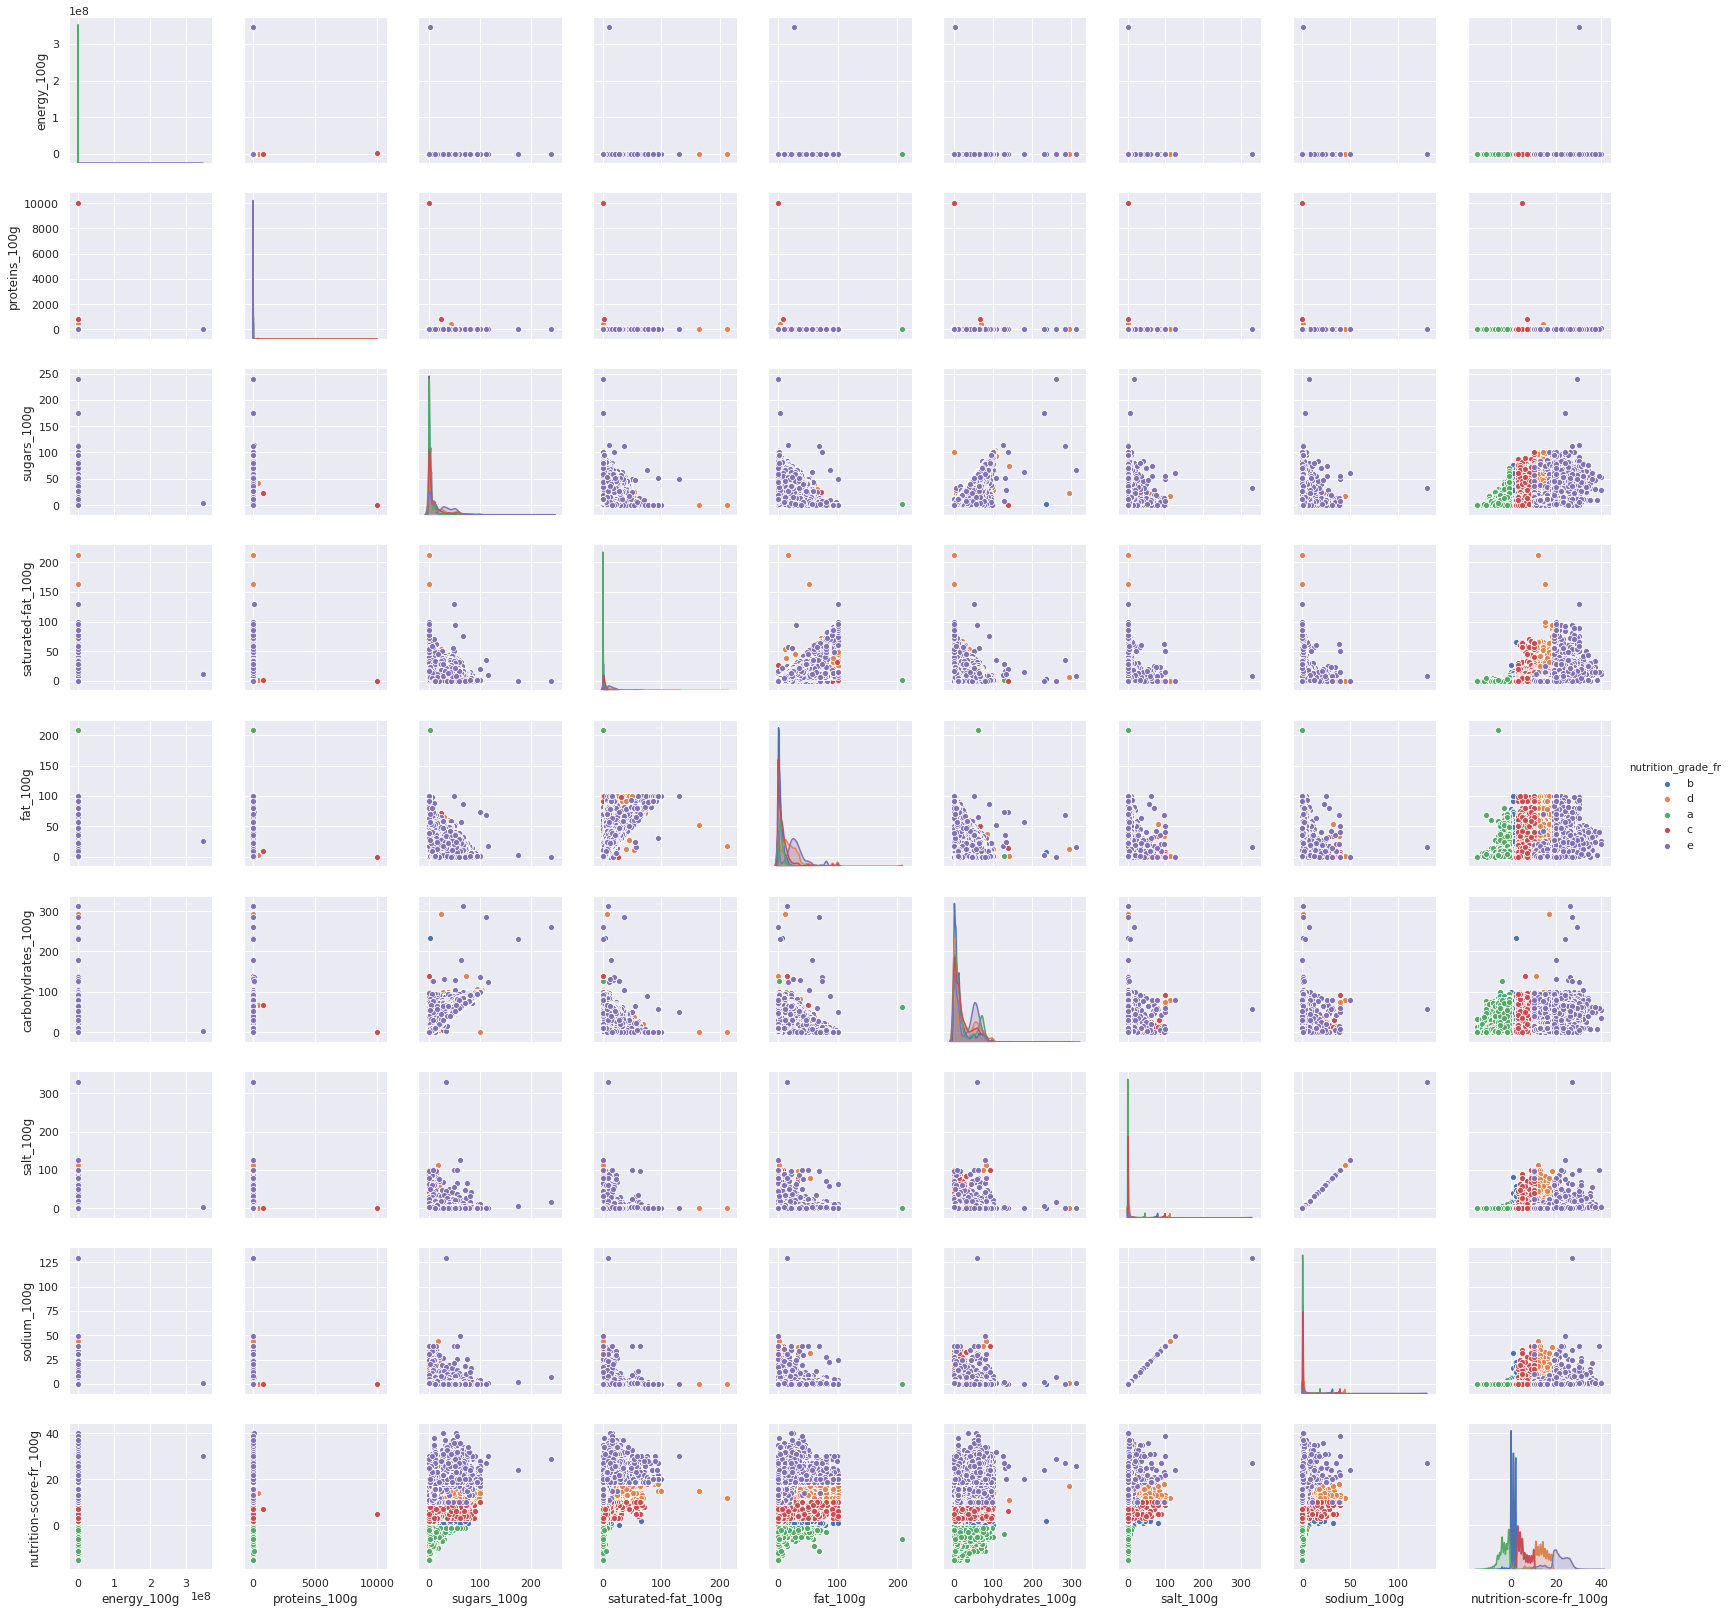

In [12]:
# Pairplot
print (data.columns)
sns.set()
sns.pairplot(data,hue='nutrition_grade_fr',vars=['energy_100g', 'proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'fat_100g','carbohydrates_100g', 'salt_100g', 'sodium_100g','nutrition-score-fr_100g'])
plt.show()

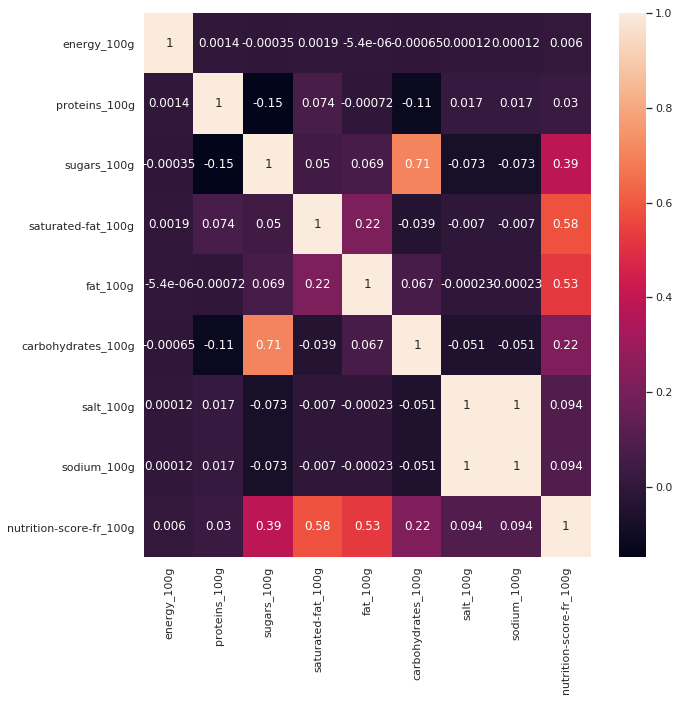

In [13]:
# Heatmap
sns.set()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data[['energy_100g', 'proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'fat_100g','carbohydrates_100g', 'salt_100g', 'sodium_100g','nutrition-score-fr_100g']].corr(),annot=True)
plt.show()


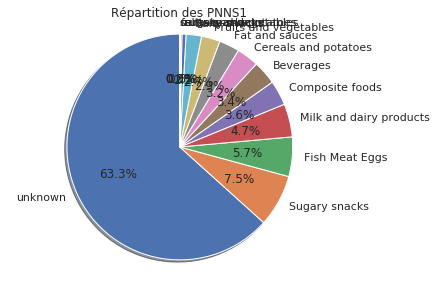

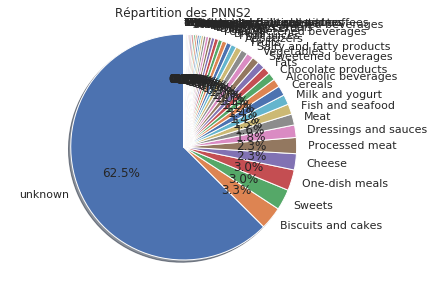

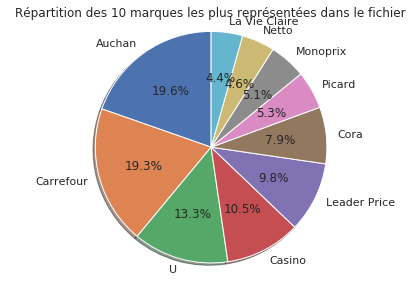

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


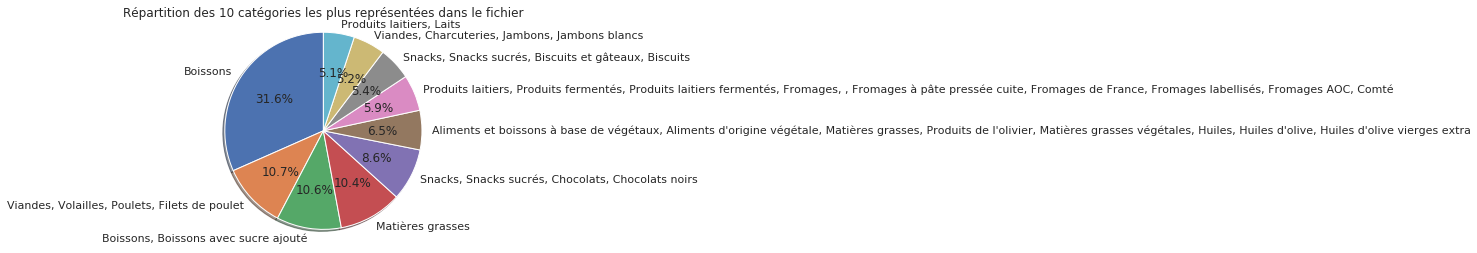

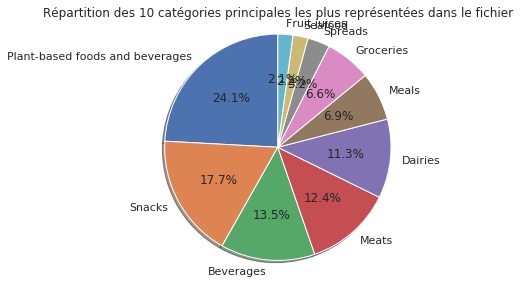

In [14]:
# Camemberts

## PNNS1

pnns1=data.groupby(['pnns_groups_1'])
countpnns1=pnns1["code"].count()
countpnns1=countpnns1.sort_values(ascending = False)

sns.set()
labels = countpnns1.index
sizes = countpnns1.values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition des PNNS1")
plt.show()

## PNNS2

pnns2=data.groupby(['pnns_groups_2'])
countpnns2=pnns2["code"].count()
countpnns2=countpnns2.sort_values(ascending = False)

sns.set()
labels = countpnns2.index
sizes = countpnns2.values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition des PNNS2")
plt.show()

## Marques

brands=data.groupby(['brands'])
countbrands=brands["code"].count()
countbrands=countbrands.sort_values(ascending = False)

sns.set()
labels = countbrands.index[0:10]
sizes = countbrands.values[0:10]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition des 10 marques les plus représentées dans le fichier")
plt.show()

## Catégories

cat=data.groupby(['categories'])
countcat=cat["code"].count()
countcat=countcat.sort_values(ascending = False)

sns.set()
labels = countcat.index[0:10]
sizes = countcat.values[0:10]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition des 10 catégories les plus représentées dans le fichier")
plt.show()

## Catégories principales

maincat=data.groupby(['main_category_en'])
countmaincat=maincat["code"].count()
countmaincat=countmaincat.sort_values(ascending = False)

sns.set()
labels = countmaincat.index[0:10]
sizes = countmaincat.values[0:10]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition des 10 catégories principales les plus représentées dans le fichier")
plt.show()

In [15]:
data.drop(['pnns_groups_1','pnns_groups_2'], axis = 1, inplace = True)

# Sauvegarde du fichier pour l'analyse
data.to_csv('fichier_nettoye_projet3.csv', sep = '\t')
print ("Fichier créé")
uploaded = drive.CreateFile({'title': 'fichier_nettoye_projet3.csv'})
uploaded.SetContentFile('fichier_nettoye_projet3.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fichier créé
Uploaded file with ID 1OQ-e-e93m6N9mSFFOeUsx0FlvGjbgwNm
